# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [ ]:
!pip install lightgbm
!pip install xgboost

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import pickle

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score, precision_score, recall_score
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from imblearn.over_sampling import SMOTE
from sklearn.cluster import KMeans
import lightgbm as lgb
import xgboost as xgb

# magic word for producing visualizations in notebook
%matplotlib inline

Using TensorFlow backend.


## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

###### I was facing issues handling azdias dataset (timeout/ workspace is idle etc.). I decided to use sample azdias instead of  the complete dataset. The size of the sample is roughly the 1/4 of the original azdias dataset. 

In [2]:
f = '../../data/Term2/capstone/arvato_data/Udacity_AZDIAS_052018.csv'
num_lines = sum(1 for l in open(f))

size = int(num_lines/10)
skip_idx = random.sample(range(1,num_lines),num_lines - size)
azdias = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_AZDIAS_052018.csv', sep=';',skiprows=skip_idx)

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
# load in the data
customers = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_CUSTOMERS_052018.csv', sep=';')

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


One thing to notice after loading both azdias and customers dataset is columns 18 and 19 are of mixed types. Let's see which columns are column 18 and 19

In [4]:
azdias.columns[18:20]

Index(['CAMEO_DEUG_2015', 'CAMEO_INTL_2015'], dtype='object')

In [5]:
azdias.CAMEO_DEUG_2015.value_counts()

8.0    6991
8      6556
9.0    5594
6.0    5424
4.0    5343
9      5135
6      5110
4      5035
3.0    4529
2.0    4283
3      4208
7.0    4158
2      3990
7      3734
5.0    2899
5      2588
1.0    1900
1      1752
X        35
Name: CAMEO_DEUG_2015, dtype: int64

In [6]:
azdias.CAMEO_INTL_2015.value_counts(0)

51.0    7028
51      6385
41.0    4842
24.0    4747
41      4530
24      4516
14.0    3180
14      3093
43.0    2783
43      2741
54.0    2354
54      2194
25.0    2125
25      1816
22.0    1674
22      1652
45.0    1413
13.0    1369
23.0    1326
23      1259
45      1253
55.0    1223
13      1209
55      1147
52.0    1061
34.0    1008
31.0     994
52       963
15.0     909
31       883
34       869
15       822
44.0     802
12.0     725
44       683
12       618
32.0     557
35       534
35.0     502
33.0     499
33       478
32       463
XX        35
Name: CAMEO_INTL_2015, dtype: int64

We need to replace X in CAMEO_DEUG_2015 and rows with value XX in CAMEO_INTL_2015 from both azdias and customers dataset. Also, notice in CAMEO_DEUG_2015 and CAMEO_DEUG_2015, 1 and 1.0 is same, as they represent the same class.  

In [7]:
def mixed_feature_handler(df):
    '''
    This function deals with the special characters in the cameo columns
    Finds the special characters and replaces them with nan
    '''
    
    cols = ['CAMEO_DEUG_2015', 'CAMEO_INTL_2015']
    df[cols] = df[cols].replace({'X': np.nan, 'XX':np.nan, '': np.nan, ' ':np.nan})
    df[cols] = df[cols].astype(float)
       
    return df

In [8]:
azdias = mixed_feature_handler(azdias)
customer = mixed_feature_handler(customers)

azdias.CAMEO_INTL_2015.value_counts()

51.0    13413
41.0     9372
24.0     9263
14.0     6273
43.0     5524
54.0     4548
25.0     3941
22.0     3326
45.0     2666
23.0     2585
13.0     2578
55.0     2370
52.0     2024
31.0     1877
34.0     1877
15.0     1731
44.0     1485
12.0     1343
35.0     1036
32.0     1020
33.0      977
Name: CAMEO_INTL_2015, dtype: int64

##### Getting some basic stats related to azdias dataset - like shape, mean, standard deviation, different percentiles

In [9]:
azdias.shape

(89121, 366)

In [10]:
azdias.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,645145,-1,9.0,16.0,NaN,NaN,NaN,NaN,16.0,2.0,...,4.0,8.0,11.0,8.0,5.0,8.0,1.0,6,1,3
1,612594,-1,7.0,0.0,NaN,NaN,NaN,NaN,NaN,1.0,...,NaN,8.0,11.0,10.0,3.0,4.0,5.0,3,2,2
2,612606,-1,8.0,0.0,NaN,NaN,NaN,NaN,NaN,14.0,...,4.0,6.0,9.0,7.0,6.0,4.0,4.0,4,1,1
3,714289,-1,9.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,8.0,11.0,10.0,0.0,9.0,NaN,3,2,3
4,796666,2,1.0,20.0,NaN,NaN,NaN,NaN,13.0,1.0,...,2.0,6.0,8.0,5.0,2.0,9.0,4.0,1,1,4


In [11]:
pd.set_option('display.max_rows', 500)
azdias.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
LNR,89121.0,636488.469957,257074.302698,191654.0,413342.0,636758.0,858179.0,1082872.0
AGER_TYP,89121.0,-0.359231,1.196795,-1.0,-1.0,-1.0,-1.0,3.0
AKT_DAT_KL,81765.0,4.422626,3.640993,1.0,1.0,3.0,9.0,9.0
ALTER_HH,81765.0,10.850021,7.643850,0.0,0.0,13.0,17.0,21.0
ALTER_KIND1,8068.0,11.741076,4.096216,2.0,8.0,12.0,15.0,18.0
ALTER_KIND2,2866.0,13.404396,3.207012,2.0,11.0,14.0,16.0,18.0
ALTER_KIND3,590.0,14.554237,2.611118,7.0,13.0,15.0,17.0,18.0
ALTER_KIND4,111.0,15.360360,2.463526,9.0,14.0,16.0,17.0,18.0
ALTERSKATEGORIE_FEIN,62785.0,13.707096,5.064649,0.0,11.0,14.0,17.0,25.0
ANZ_HAUSHALTE_AKTIV,79896.0,8.265708,15.449825,0.0,1.0,4.0,10.0,595.0


##### Getting some basic stats related to customers dataset - like shape, mean, standard deviation, different percentiles

In [12]:
customers.shape

(191652, 369)

In [13]:
customers.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,9626,2,1.0,10.0,NaN,NaN,NaN,NaN,10.0,1.0,...,2.0,6.0,9.0,7.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,4
1,9628,-1,9.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,...,3.0,0.0,9.0,NaN,3,FOOD,SINGLE_BUYER,0,1,4
2,143872,-1,1.0,6.0,NaN,NaN,NaN,NaN,0.0,1.0,...,11.0,6.0,9.0,2.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,2,4
3,143873,1,1.0,8.0,NaN,NaN,NaN,NaN,8.0,0.0,...,2.0,NaN,9.0,7.0,1,COSMETIC,MULTI_BUYER,0,1,4
4,143874,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,7.0,...,4.0,2.0,9.0,3.0,1,FOOD,MULTI_BUYER,0,1,3


In [ ]:
customers.describe().transpose()

Next, I am reading description of these columns to get an idea what these attributes really means.

In [14]:
dias_information = pd.read_excel('./DIAS Information Levels - Attributes 2017.xlsx')
dias_information.drop('Unnamed: 0', axis=1, inplace=True)
dias_information.head(10)

,Information level,Attribute,Description,Additional notes
0,NaN,AGER_TYP,best-ager typology,in cooperation with Kantar TNS; the informatio...
1,Person,ALTERSKATEGORIE_GROB,age through prename analysis,modelled on millions of first name-age-referen...
2,NaN,ANREDE_KZ,gender,NaN
3,NaN,CJT_GESAMTTYP,Customer-Journey-Typology relating to the pref...,"relating to the preferred information, marketi..."
4,NaN,FINANZ_MINIMALIST,financial typology: low financial interest,Gfk-Typology based on a representative househo...
5,NaN,FINANZ_SPARER,financial typology: money saver,NaN
6,NaN,FINANZ_VORSORGER,financial typology: be prepared,NaN
7,NaN,FINANZ_ANLEGER,financial typology: investor,NaN
8,NaN,FINANZ_UNAUFFAELLIGER,financial typology: unremarkable,NaN
9,NaN,FINANZ_HAUSBAUER,financial typology: main focus is the own house,NaN


In [15]:
dias_attributes = pd.read_excel('./DIAS Attributes - Values 2017.xlsx')
dias_attributes.drop('Unnamed: 0', axis=1, inplace=True)
dias_attributes.head(10)

,Attribute,Description,Value,Meaning
0,AGER_TYP,best-ager typology,-1,unknown
1,NaN,NaN,0,no classification possible
2,NaN,NaN,1,passive elderly
3,NaN,NaN,2,cultural elderly
4,NaN,NaN,3,experience-driven elderly
5,ALTERSKATEGORIE_GROB,age classification through prename analysis,"-1, 0",unknown
6,NaN,NaN,1,< 30 years
7,NaN,NaN,2,30 - 45 years
8,NaN,NaN,3,46 - 60 years
9,NaN,NaN,4,> 60 years


It's not feasible to print out the whole attributes file, as it has ~2.3k rows. I will download the DIAS Attributes - Values 2017.xlsx file to see what different values means in different categories.

#### Convert missing value codes to NaN

I want to identify all the values which are unknown or contain no in the meaning string. First, I will filter the dias_attribute data frame and using which the same I will replace the missing value code with NaNs. 

In [16]:
dias_attributes['Attribute'] = dias_attributes['Attribute'].fillna(method='ffill')
dias_attributes = dias_attributes[(dias_attributes['Meaning'].str.contains("unknown") | dias_attributes['Meaning'].str.contains("no "))]
dias_attributes[290:]

,Attribute,Description,Value,Meaning
2194,SEMIO_VERT,affinity indicating in what way the person is ...,"-1, 9",unknown
2202,SHOPPER_TYP,shopping typology,-1,unknown
2207,SOHO_FLAG,small office/home office flag,-1,unknown
2208,SOHO_FLAG,NaN,0,no small office/home office
2210,TITEL_KZ,flag whether this person holds an academic title,"-1, 0",unknown
2216,VERS_TYP,insurance typology,-1,unknown
2219,WOHNDAUER_2008,length of residence,"-1, 0",unknown
2229,WOHNLAGE,residential-area,-1,unknown
2230,WOHNLAGE,NaN,0,no score calculated
2238,WACHSTUMSGEBIET_NB,growing area (population growth in the last 5 ...,"-1, 0",unknown


In [17]:
unknowns = []
features = []

for feature in dias_attributes['Attribute'].unique():
    missing_or_unknown = dias_attributes.loc[dias_attributes['Attribute'] == feature, 'Value'].astype(str).str.cat(sep=',').split(',')
    unknowns.append(missing_or_unknown)
    features.append(feature)
    
unknowns_df = pd.concat([pd.Series(features), pd.Series(unknowns)], axis=1)
unknowns_df.columns = ['attribute', 'missing_or_unknown']
unknowns_df.head()

,attribute,missing_or_unknown
0,AGER_TYP,"[-1, 0]"
1,ALTERSKATEGORIE_GROB,"[-1, 0]"
2,ALTER_HH,[0]
3,ANREDE_KZ,"[-1, 0]"
4,BALLRAUM,[-1]


### Replacing Nan's code with Nan values

In [18]:
def replacing_with_nan(df,unknowns_df):
    for row in unknowns_df['attribute']:
        if row in df.columns:
            na_map = unknowns_df.loc[unknowns_df['attribute'] == row, 'missing_or_unknown'].iloc[0]
            na_idx = df.loc[:, row].isin(na_map)
            df.loc[na_idx, row] = np.NaN
        else:
            continue
            
    return df

Replacing unknown code values with NaN for both customers and azdias dataset.

In [19]:
customers = replacing_with_nan(customers,unknowns_df)
customers.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,9626,2.0,1.0,10.0,NaN,NaN,NaN,NaN,10.0,1.0,...,2.0,6.0,9.0,7.0,3.0,COSMETIC_AND_FOOD,MULTI_BUYER,0,1.0,4.0
1,9628,NaN,9.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,...,3.0,NaN,9.0,NaN,3.0,FOOD,SINGLE_BUYER,0,1.0,4.0
2,143872,NaN,1.0,6.0,NaN,NaN,NaN,NaN,0.0,1.0,...,11.0,6.0,9.0,2.0,3.0,COSMETIC_AND_FOOD,MULTI_BUYER,0,2.0,4.0
3,143873,1.0,1.0,8.0,NaN,NaN,NaN,NaN,8.0,0.0,...,2.0,NaN,9.0,7.0,1.0,COSMETIC,MULTI_BUYER,0,1.0,4.0
4,143874,NaN,1.0,20.0,NaN,NaN,NaN,NaN,14.0,7.0,...,4.0,2.0,9.0,3.0,1.0,FOOD,MULTI_BUYER,0,1.0,3.0


In [20]:
azdias = replacing_with_nan(azdias,unknowns_df)
azdias.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,645145,NaN,9.0,16.0,NaN,NaN,NaN,NaN,16.0,2.0,...,4.0,8.0,11.0,8.0,5.0,8.0,1.0,6.0,1.0,3.0
1,612594,NaN,7.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,...,NaN,8.0,11.0,10.0,3.0,4.0,5.0,3.0,2.0,2.0
2,612606,NaN,8.0,NaN,NaN,NaN,NaN,NaN,NaN,14.0,...,4.0,6.0,9.0,7.0,6.0,4.0,4.0,4.0,1.0,1.0
3,714289,NaN,9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,8.0,11.0,10.0,NaN,9.0,NaN,3.0,2.0,3.0
4,796666,2.0,1.0,20.0,NaN,NaN,NaN,NaN,13.0,1.0,...,2.0,6.0,8.0,5.0,2.0,9.0,4.0,1.0,1.0,4.0


### Deleting columns with null values

##### Handing Null Values and checking their distributions

First, let's see what is the distribution of null values accross the columns. I am going to create a dataframe to store the percentage of null values in columns.

In [21]:
def identify_columns_null_values(df):
    
    '''
    This function takes a dataframe as an input and resturn a list of all the columns where
    null values are more than 40% of the total values in the column
    '''

    df_null = df.isnull().sum()
    df_null_percent = df_null / len(df) * 100

    df_null_percent.sort_values()[330:].plot.barh(figsize=(10,10),fontsize=12,color='teal')
    print('columns having  missing values >40% : ',len(df_null_percent[df_null_percent>40].index))
    
    df_null_list = list(df_null_percent[df_null_percent>40].index)
    return df_null_list

columns having  missing values >40% :  37


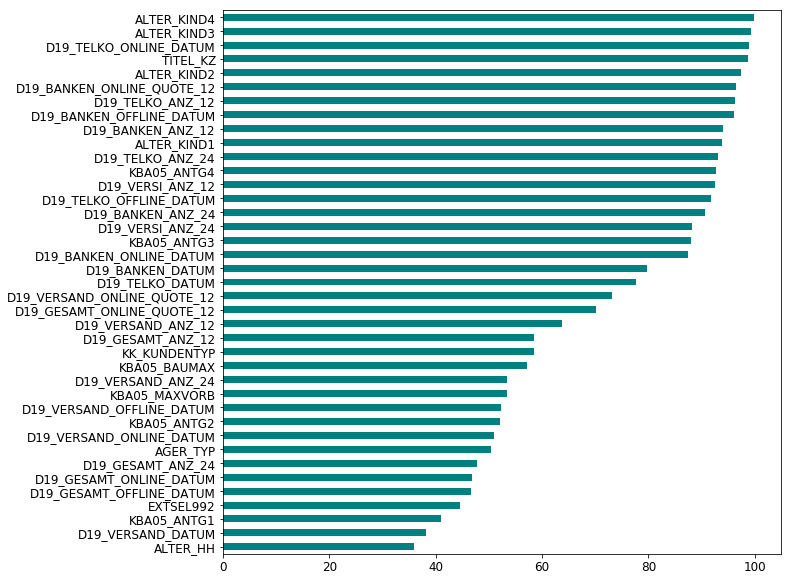

In [22]:
customers_null_list = identify_columns_null_values(customers)

columns having  missing values >40% :  37


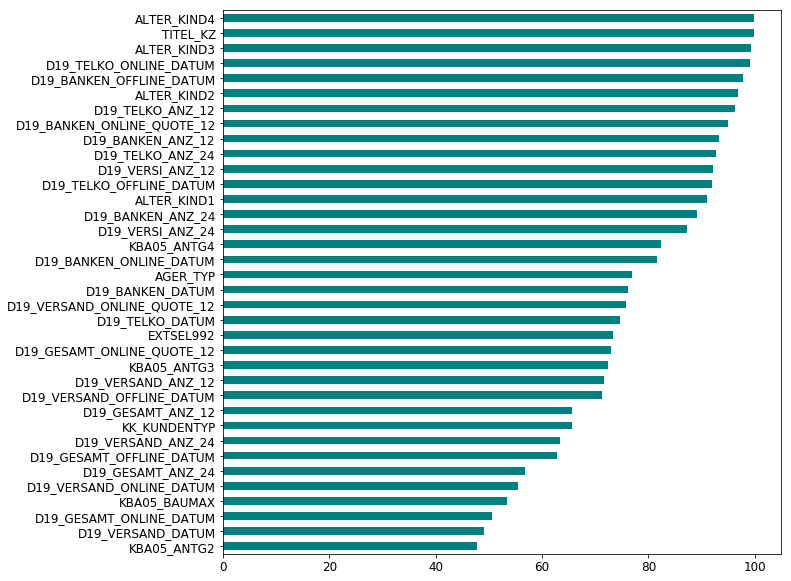

In [23]:
azdias_null_list = identify_columns_null_values(azdias)

In [24]:
len(list(set(customers_null_list) & set(azdias_null_list)))

36

There are 36 columns where 40% of the values are null are common in both azdias and customers dataset. 

In [25]:
len(list(set(customers_null_list) | set(azdias_null_list)))

38

However, to remain consistent we need to remove all 38 columns from both the dataset.

In [26]:
columns_to_drop = list(set(customers_null_list) | set(azdias_null_list))

In [27]:
azdias.drop(columns_to_drop, axis=1, inplace = True)
customers.drop(columns_to_drop, axis=1, inplace = True)

In [28]:
print(azdias.shape)
print(customers.shape)

(89121, 328)
(191652, 331)


### Removing rows with missing values

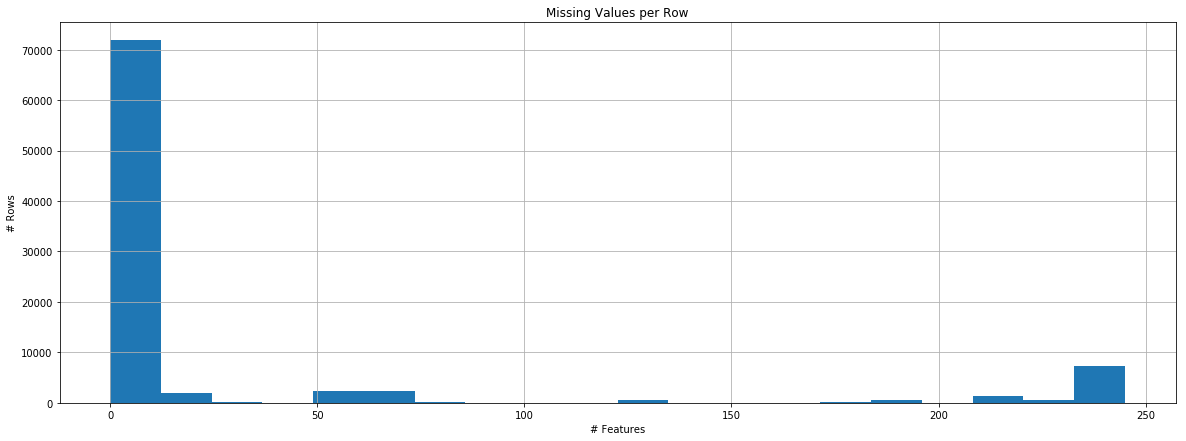

In [29]:
fig = plt.figure(figsize=(20,7))
azdias.isnull().sum(axis=1).hist(bins=20)
plt.title('Missing Values per Row');
plt.xlabel('# Features')
plt.ylabel('# Rows');

I'll use a threshold of 230 which means that rows that have more than 230 features missing will be dropped.

In [30]:
azdias = azdias.dropna(thresh=230)
azdias.shape

(78616, 328)

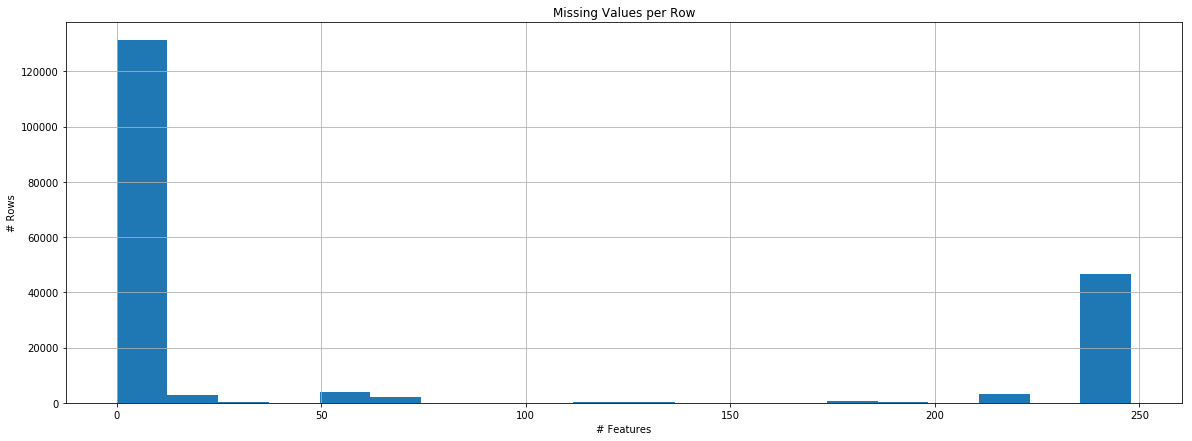

In [31]:
fig = plt.figure(figsize=(20,7))
customers.isnull().sum(axis=1).hist(bins=20)
plt.title('Missing Values per Row');
plt.xlabel('# Features')
plt.ylabel('# Rows');

In [32]:
customers = customers.dropna(thresh=230)
customers.shape

(140371, 331)

### Encoding features and feature engineering

In [33]:
extra_col = list(set(customers.columns) - set(azdias.columns))
extra_col

['PRODUCT_GROUP', 'ONLINE_PURCHASE', 'CUSTOMER_GROUP']

We have three extra columns in customers dataset. We need to remove these three columns from the customers dataset.

In [34]:
customers = customers.copy(deep=True)
azdias = azdias.copy(deep=True)

customers.drop(extra_col, axis = 1, inplace = True)

From manual investigation, I found out that there are 6 numerical columns   

In [35]:
print(azdias.shape)
print(customers.shape)

(78616, 328)
(140371, 328)


Next, I will identify the columns with only two values so that I can convert them in binary columns.

In [36]:
categorical_binary=[]

for feature in azdias.columns:
    if azdias[feature].nunique() == 2:
        categorical_binary.append(feature)
        
categorical_binary

['DSL_FLAG',
 'GREEN_AVANTGARDE',
 'HH_DELTA_FLAG',
 'KBA05_SEG6',
 'KONSUMZELLE',
 'OST_WEST_KZ',
 'SOHO_KZ',
 'UNGLEICHENN_FLAG',
 'VERS_TYP',
 'ANREDE_KZ']

In [ ]:
for col in categorical_binary:
    print(azdias[col].value_counts())

In [ ]:
#we need to convert OST_WEST_KZ categories from W and O to 0 and 1
o_w_k_dict = {'W':0, 'O':1}
azdias['OST_WEST_KZ'] = azdias['OST_WEST_KZ'].apply(lambda x:o_w_k_dict[x])
customers['OST_WEST_KZ'] = customers['OST_WEST_KZ'].apply(lambda x:o_w_k_dict[x])

I have identified a few columns, using which I will be creating a few other columns, in order to capture information in a better way.

In [ ]:
#extract the time,and keep the year for column with date/time information
azdias['EINGEFUEGT_AM']=pd.to_datetime(azdias['EINGEFUEGT_AM']).dt.year
customers['EINGEFUEGT_AM']=pd.to_datetime(customers['EINGEFUEGT_AM']).dt.year

In [ ]:
#extracting decade
decades_dict = {1: 40, 2: 40, 3: 50, 4: 50, 5: 60, 6: 60, 7: 60,
           8: 70, 9: 70, 10: 80, 11: 80, 12: 80, 13: 80, 14: 90,
           15: 90,0: np.nan}

#mainstream or avant-garde movement
movement_dict = {1: 0, 2: 1, 3: 0, 4: 1, 5: 0, 6: 1, 7: 1, 8: 0,
           9: 1, 10: 0, 11: 1, 12: 0, 13: 1, 14: 0, 15: 1,0: np.nan}

azdias['PRAEGENDE_JUGENDJAHRE_DECADE'] = azdias['PRAEGENDE_JUGENDJAHRE'].map(decades_dict)
customers['PRAEGENDE_JUGENDJAHRE_DECADE'] = customers['PRAEGENDE_JUGENDJAHRE'].map(decades_dict)

azdias['PRAEGENDE_JUGENDJAHRE_MOVEMENT'] = azdias['PRAEGENDE_JUGENDJAHRE'].map(movement_dict)
customers['PRAEGENDE_JUGENDJAHRE_MOVEMENT'] = customers['PRAEGENDE_JUGENDJAHRE'].map(movement_dict)

In [ ]:
#Using CAMEO_INTL_2015 to create a wealth and family type feature
azdias['WEALTH'] = azdias['CAMEO_INTL_2015'].apply(lambda x: np.floor(pd.to_numeric(x)/10))
azdias['LIFE_STAGE'] = azdias['CAMEO_INTL_2015'].apply(lambda x: pd.to_numeric(x)%10)

customers['WEALTH'] = customers['CAMEO_INTL_2015'].apply(lambda x: np.floor(pd.to_numeric(x)/10))
customers['LIFE_STAGE'] = customers['CAMEO_INTL_2015'].apply(lambda x: pd.to_numeric(x)%10)

In [ ]:
#dealing with LP_LEBENSPHASE_FEIN
life_stage = {1: 'younger_age', 2: 'middle_age', 3: 'younger_age',
              4: 'middle_age', 5: 'advanced_age', 6: 'retirement_age',
              7: 'advanced_age', 8: 'retirement_age', 9: 'middle_age',
              10: 'middle_age', 11: 'advanced_age', 12: 'retirement_age',
              13: 'advanced_age', 14: 'younger_age', 15: 'advanced_age',
              16: 'advanced_age', 17: 'middle_age', 18: 'younger_age',
              19: 'advanced_age', 20: 'advanced_age', 21: 'middle_age',
              22: 'middle_age', 23: 'middle_age', 24: 'middle_age',
              25: 'middle_age', 26: 'middle_age', 27: 'middle_age',
              28: 'middle_age', 29: 'younger_age', 30: 'younger_age',
              31: 'advanced_age', 32: 'advanced_age', 33: 'younger_age',
              34: 'younger_age', 35: 'younger_age', 36: 'advanced_age',
              37: 'advanced_age', 38: 'retirement_age', 39: 'middle_age',
              40: 'retirement_age'}

fine_scale = {1: 'low', 2: 'low', 3: 'average', 4: 'average', 5: 'low', 6: 'low',
              7: 'average', 8: 'average', 9: 'average', 10: 'wealthy', 11: 'average',
              12: 'average', 13: 'top', 14: 'average', 15: 'low', 16: 'average',
              17: 'average', 18: 'wealthy', 19: 'wealthy', 20: 'top', 21: 'low',
              22: 'average', 23: 'wealthy', 24: 'low', 25: 'average', 26: 'average',
              27: 'average', 28: 'top', 29: 'low', 30: 'average', 31: 'low',
              32: 'average', 33: 'average', 34: 'average', 35: 'top', 36: 'average',
              37: 'average', 38: 'average', 39: 'top', 40: 'top'}

life_dict = {'younger_age': 1, 'middle_age': 2, 'advanced_age': 3,
            'retirement_age': 4}
scale_dict = {'low': 1, 'average': 2, 'wealthy': 3, 'top': 4}

azdias['LP_LEBENSPHASE_FEIN_life_stage'] = azdias['LP_LEBENSPHASE_FEIN'].map(life_stage)
azdias['LP_LEBENSPHASE_FEIN_fine_scale'] = azdias['LP_LEBENSPHASE_FEIN'].map(fine_scale)
azdias['LP_LEBENSPHASE_FEIN_life_stage'] = azdias['LP_LEBENSPHASE_FEIN_life_stage'].map(life_dict)
azdias['LP_LEBENSPHASE_FEIN_fine_scale'] = azdias['LP_LEBENSPHASE_FEIN_fine_scale'].map(scale_dict)


customers['LP_LEBENSPHASE_FEIN_life_stage'] = customers['LP_LEBENSPHASE_FEIN'].map(life_stage)
customers['LP_LEBENSPHASE_FEIN_fine_scale'] = customers['LP_LEBENSPHASE_FEIN'].map(fine_scale)
customers['LP_LEBENSPHASE_FEIN_life_stage'] = customers['LP_LEBENSPHASE_FEIN_life_stage'].map(life_dict)
customers['LP_LEBENSPHASE_FEIN_fine_scale'] = customers['LP_LEBENSPHASE_FEIN_fine_scale'].map(scale_dict)

In [ ]:
#dropping columns used to create new features
#Also deleting column LP_LEBENSPHASE_FEIN as it contains same information as 
cols = ['PRAEGENDE_JUGENDJAHRE','CAMEO_INTL_2015' ,'LP_LEBENSPHASE_FEIN','LP_LEBENSPHASE_GROB']
    
azdias.drop(cols, axis = 1, inplace = True)
customers.drop(cols, axis = 1, inplace = True)

In [ ]:
print(azdias.shape)
print(customers.shape)

I have identified a few categorical columns where I will be applying One hot encoding and the rest I will be treating as numerical columns. 

In [ ]:
cat_features = ['CAMEO_DEU_2015','CAMEO_DEUG_2015','CJT_GESAMTTYP','D19_KONSUMTYP',
                'D19_LETZTER_KAUF_BRANCHE','FINANZTYP','GEBAEUDETYP','GEBAEUDETYP_RASTER','GFK_URLAUBERTYP',
                'HEALTH_TYP','KBA05_HERSTTEMP','KBA05_MAXHERST','KBA05_MAXSEG',
                'LP_FAMILIE_FEIN','KBA05_MODTEMP','LP_FAMILIE_GROB','RETOURTYP_BK_S',
                'LP_STATUS_FEIN','LP_STATUS_GROB','NATIONALITAET_KZ','SHOPPER_TYP','ZABEOTYP','WOHNLAGE']

azdias_cat_ohe = pd.get_dummies(azdias, columns = cat_features)
customers_cat_ohe = pd.get_dummies(customers, columns = cat_features)

In [ ]:
print(azdias_cat_ohe.shape)
print(customers_cat_ohe.shape)

### Imputing missing values with most frquent value

Initially I tried Imputer from sklearn but received an error "could not convert string to float: 'W'". That's why I decided to write my custom impute function  

In [37]:
def impute(df):
    """
    Imputes the most frequent value per column.
    """
    df_copy = df.copy()
    columns = df_copy.columns[df_copy.isnull().any()]
    
    for col in columns:
        most_freq = df_copy.groupby([col])[col].count().sort_values(ascending=False).index[0]
        df_copy[col].fillna(most_freq, inplace=True)
    
    return df_copy

In [ ]:
azdias_impute = impute(azdias_cat_ohe)
azdias.head()

In [ ]:
customers_impute = impute(customers_cat_ohe)
customers.head()

In [ ]:
import pickle

# Dump the dataframe to a pickle object so that I don't have to run the process every time
pickle.dump(azdias_impute, open("azdias_impute.pickle", "wb"))
pickle.dump(customers_impute, open("customers_impute.pickle", "wb"))

As we can see the number of columns is 519, which is very high. The next logical step would be to apply a dimensionality reduction technique to reduce the number of columns(dimensions). I will apply standard scaling to the features before applying PCA, so that principal component vectors won't get affected by variation in the data

In [ ]:
# Reload cleaned azdias object as saved after above analysis (may need to rerun imports)
azdias_impute = pickle.load(open("azdias_impute.pickle", "rb"))
customers_impute = pickle.load(open("customers_impute.pickle", "rb"))

In [ ]:
scaler = MinMaxScaler()
azdias_scaled = scaler.fit_transform(azdias_impute.astype(float))
customers_scaled = scaler.fit_transform(customers_impute.astype(float))

### Perform Dimensionality Reduction

In [ ]:
pca_azdias = PCA()
azdias_pca = pca_azdias.fit_transform(azdias_scaled)

In [ ]:
plt.plot(np.cumsum(pca_azdias.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance Ratio vs Number of Components in azdias dataset')
plt.grid(b=True)

In [ ]:
pca_customers = PCA()
customers_pca = pca_customers.fit_transform(customers_scaled)

In [ ]:
plt.plot(np.cumsum(pca_customers.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance Ratio vs Number of Components in customers dataset')
plt.grid(b=True)

As we can see from the Explained varince ratio vs Number of components graph, approximately 150 components covers more than 80% of the variance. I will refit the PCA with 150 components to cover 80+% of the variance in the datset. 

###### Interpreting Dimensionality Reduction

In [ ]:
def identify_important_features(df,pca,component):
    '''
    This function returns the top 5 features (both negative and positive contibution) 
    in a particular component
    '''
    features = df.columns.values
    components = pca.components_
    feature_weights = dict(zip(features, components[component]))
    feature_weights = {k: v for k, v in sorted(feature_weights.items(), key=lambda x: abs(x[1]))}
    
    print("Component with highest contribution")
    for key in list(feature_weights.keys())[:10]:
        print(key,feature_weights[key])

In [ ]:
identify_important_features(azdias,pca_azdias,0)

In [ ]:
identify_important_features(customers,pca_customers,0)

As we can see, features (ANZ_TITEL, LP_LEBENSPHASE_FEIN_fine_scale, D19_SCHUHE, REGIOTYP  etc.) are common in the first component of both the pca's. 

## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

##### Running PCA again with 150 components

In [ ]:
pca1 = PCA(150)
azdias_pca = pca1.fit_transform(azdias_scaled)

pca2 = PCA(150)
customers_pca = pca2.fit_transform(customers_scaled)

In [ ]:
Sum_of_squared_distances = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(azdias_pca)
    Sum_of_squared_distances.append(km.inertia_)

In [ ]:
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [ ]:
# from the elbow curve we can the optimum number of clusters is 10, refitting kmeans with 10 clusters

kmeans = KMeans(n_clusters=10, random_state=42, n_jobs=-1)
azdias_predictions = kmeans.fit_predict(azdias_pca)
customers_predictions = kmeans.predict(customers_pca)

In [ ]:
#checking predictions
customers_predictions[:20]

In [ ]:
# Count number of predictions for each customer segment and population segment 
customer_clusters = pd.Series(customers_predictions)
cc = customer_clusters.value_counts().sort_index()

population_clusters = pd.Series(azdias_predictions)
pc = population_clusters.value_counts().sort_index()

df_stat = pd.concat([pc, cc], axis=1).reset_index()
df_stat.columns = ['cluster','population','customer']

total_customer = sum(df_stat.customer.values)
total_population = sum(df_stat.population.values)

df_stat.population = df_stat['population'].apply(lambda x:(x/total_population)*100)
df_stat.customer = df_stat['customer'].apply(lambda x:(x/total_customer)*100)

df_stat

Cluster 1,2,4 and 6 represent the biggest chunk for the customer dataset. The mail order company can target people in the same cluster from the general population. As general population of cluster 1,2,4 and 6 is similar in charcteristics with the customers, chances are more they will respond to the promotion.   

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [38]:
mailout_train = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [39]:
X = mailout_train.drop('RESPONSE',axis=1)
target = mailout_train['RESPONSE']

In [40]:
def data_process(X,unknowns_df,columns_to_drop):
    '''
    This function performs all the cleaning steps and return the final dataset ready for the machine learning
    '''
    df = X.copy(deep=True)
    print("Shape of dataframe - rows {} columns {}".format(df.shape[0],df.shape[1]))
    df = mixed_feature_handler(df)
    df = replacing_with_nan(df,unknowns_df)
    df.drop(columns_to_drop, axis=1, inplace = True)
    print("Shape of dataframe after droping columns - rows {} columns {}".format(df.shape[0],df.shape[1]))
    
    o_w_k_dict = {'W':0, 'O':1,np.nan:0}
    df['OST_WEST_KZ'] = df['OST_WEST_KZ'].apply(lambda x:o_w_k_dict[x])
    df['EINGEFUEGT_AM']=pd.to_datetime(df['EINGEFUEGT_AM']).dt.year
    
    #extracting decade
    decades_dict = {1: 40, 2: 40, 3: 50, 4: 50, 5: 60, 6: 60, 7: 60,
           8: 70, 9: 70, 10: 80, 11: 80, 12: 80, 13: 80, 14: 90,
           15: 90,0: np.nan}

    #mainstream or avant-garde movement
    movement_dict = {1: 0, 2: 1, 3: 0, 4: 1, 5: 0, 6: 1, 7: 1, 8: 0,
           9: 1, 10: 0, 11: 1, 12: 0, 13: 1, 14: 0, 15: 1,0: np.nan}

    df['PRAEGENDE_JUGENDJAHRE_DECADE'] = df['PRAEGENDE_JUGENDJAHRE'].map(decades_dict)
    df['PRAEGENDE_JUGENDJAHRE_MOVEMENT'] = df['PRAEGENDE_JUGENDJAHRE'].map(movement_dict)
    
    #Using CAMEO_INTL_2015 to create a wealth and family type feature
    df['WEALTH'] = df['CAMEO_INTL_2015'].apply(lambda x: np.floor(pd.to_numeric(x)/10))
    df['LIFE_STAGE'] = df['CAMEO_INTL_2015'].apply(lambda x: pd.to_numeric(x)%10)

    #dealing with LP_LEBENSPHASE_FEIN
    life_stage = {1: 'younger_age', 2: 'middle_age', 3: 'younger_age',
              4: 'middle_age', 5: 'advanced_age', 6: 'retirement_age',
              7: 'advanced_age', 8: 'retirement_age', 9: 'middle_age',
              10: 'middle_age', 11: 'advanced_age', 12: 'retirement_age',
              13: 'advanced_age', 14: 'younger_age', 15: 'advanced_age',
              16: 'advanced_age', 17: 'middle_age', 18: 'younger_age',
              19: 'advanced_age', 20: 'advanced_age', 21: 'middle_age',
              22: 'middle_age', 23: 'middle_age', 24: 'middle_age',
              25: 'middle_age', 26: 'middle_age', 27: 'middle_age',
              28: 'middle_age', 29: 'younger_age', 30: 'younger_age',
              31: 'advanced_age', 32: 'advanced_age', 33: 'younger_age',
              34: 'younger_age', 35: 'younger_age', 36: 'advanced_age',
              37: 'advanced_age', 38: 'retirement_age', 39: 'middle_age',
              40: 'retirement_age'}

    fine_scale = {1: 'low', 2: 'low', 3: 'average', 4: 'average', 5: 'low', 6: 'low',
              7: 'average', 8: 'average', 9: 'average', 10: 'wealthy', 11: 'average',
              12: 'average', 13: 'top', 14: 'average', 15: 'low', 16: 'average',
              17: 'average', 18: 'wealthy', 19: 'wealthy', 20: 'top', 21: 'low',
              22: 'average', 23: 'wealthy', 24: 'low', 25: 'average', 26: 'average',
              27: 'average', 28: 'top', 29: 'low', 30: 'average', 31: 'low',
              32: 'average', 33: 'average', 34: 'average', 35: 'top', 36: 'average',
              37: 'average', 38: 'average', 39: 'top', 40: 'top'}

    life_dict = {'younger_age': 1, 'middle_age': 2, 'advanced_age': 3,
            'retirement_age': 4}
    scale_dict = {'low': 1, 'average': 2, 'wealthy': 3, 'top': 4}

    df['LP_LEBENSPHASE_FEIN_life_stage'] = df['LP_LEBENSPHASE_FEIN'].map(life_stage)
    df['LP_LEBENSPHASE_FEIN_fine_scale'] = df['LP_LEBENSPHASE_FEIN'].map(fine_scale)
    df['LP_LEBENSPHASE_FEIN_life_stage'] = df['LP_LEBENSPHASE_FEIN_life_stage'].map(life_dict)
    df['LP_LEBENSPHASE_FEIN_fine_scale'] = df['LP_LEBENSPHASE_FEIN_fine_scale'].map(scale_dict)


    cols = ['PRAEGENDE_JUGENDJAHRE','CAMEO_INTL_2015' ,'LP_LEBENSPHASE_FEIN','LP_LEBENSPHASE_GROB']
    
    df.drop(cols, axis = 1, inplace = True)
    
    print("Shape of dataframe after feature engineering - rows {} columns {}".format(df.shape[0],df.shape[1]))
    
    cat_features = ['CAMEO_DEU_2015','CAMEO_DEUG_2015','CJT_GESAMTTYP','D19_KONSUMTYP',
                'D19_LETZTER_KAUF_BRANCHE','FINANZTYP','GEBAEUDETYP','GEBAEUDETYP_RASTER','GFK_URLAUBERTYP',
                'HEALTH_TYP','KBA05_HERSTTEMP','KBA05_MAXHERST','KBA05_MAXSEG',
                'LP_FAMILIE_FEIN','KBA05_MODTEMP','LP_FAMILIE_GROB','RETOURTYP_BK_S',
                'LP_STATUS_FEIN','LP_STATUS_GROB','NATIONALITAET_KZ','SHOPPER_TYP','ZABEOTYP','WOHNLAGE']

    df_cat_ohe = pd.get_dummies(df, columns = cat_features)
    
    print("Shape of dataframe after OHE - rows {} columns {}".format(df.shape[0],df.shape[1])) 
    
    df_impute = impute(df_cat_ohe)
    
    print("Shape of dataframe after imputation - rows {} columns {}".format(df.shape[0],df.shape[1])) 
    
    return df_impute


In [41]:
mail_df = data_process(X,unknowns_df,columns_to_drop)

Shape of dataframe - rows 42962 columns 366
Shape of dataframe after droping columns - rows 42962 columns 328
Shape of dataframe after feature engineering - rows 42962 columns 330
Shape of dataframe after OHE - rows 42962 columns 330
Shape of dataframe after imputation - rows 42962 columns 330


In [42]:
scaler = MinMaxScaler()
mail_df = scaler.fit_transform(mail_df.astype(float))

In [43]:
X_train, X_test, y_train, y_test = train_test_split(mail_df, target, test_size=0.25, random_state=27)

#### Base Model

I am creating a simple logistic regression as a base model. I will create further advance model and compare their performance with the base model.     

In [44]:
model_lr = LogisticRegression(random_state=12,max_iter=500)

grid_lr = GridSearchCV(estimator=model_lr, param_grid={}, scoring='roc_auc', cv=5)
grid_lr.fit(X_train, y_train)
print(grid_lr.best_score_)

0.674382798042


In [45]:
preds = grid_lr.predict(X_test)
print("AUC for test dataset {}".format(roc_auc_score(y_test,preds)))

AUC for test dataset 0.49990567817392945


AU-ROC of our simple base model is 67% on the cross validation but performace on the test set is poor. Since the data is unbalanced, I am going to try generate synthetic samples using SMOTE. I am taking reference from the link: https://towardsdatascience.com/methods-for-dealing-with-imbalanced-data-5b761be45a18

In [92]:
sm = SMOTE(random_state=27)
X_train_syn, y_train_syn = sm.fit_sample(X_train, y_train)

In [51]:
import warnings
warnings.filterwarnings("ignore")

model_lr = LogisticRegression(random_state=12,max_iter=500)
grid_lr = GridSearchCV(estimator=model_lr, param_grid={}, scoring='roc_auc', cv=5)
grid_lr.fit(X_train_syn, y_train_syn)
print(grid_lr.best_score_)

0.897983161873


In [52]:
preds = grid_lr.predict(X_test)
print("AUC for test dataset {}".format(roc_auc_score(y_test,preds)))

AUC for test dataset 0.5547551771825324


As we can see the logistic regression model trained on synthetic sampled train data is performing better than the simple logistic regression model.

### More advanced model

I am using XG-Boost and Light GBM models as these algorithms are know for their performance. 

In [60]:
sm = SMOTE(random_state=27)
X_train_syn, y_train_syn = sm.fit_sample(mail_df, target)

In [76]:
#First XG-B model

#xgb_model = xgb.XGBClassifier(eta= 0.1, gamma= 1, min_child_weight= 1,
#                              colsample_bytree= 0.8, max_bin= 256, objective= "binary:logistic",
#                              tree_method= "hist", silent= 1, base_score=0.5, 
#                              eval_metric='auc', booster='gbtree', learning_rate=0.005,
#                              max_depth=5, missing=None,n_estimators=500, n_jobs=-1,
#                              nthread=None, random_state=0,reg_alpha=1e-09, 
#                              reg_lambda=1, scale_pos_weight=1, seed=1, subsample=0.5)

xgb_model = xgb.XGBClassifier()

In [77]:
#xgb_model.fit(X_train_syn, y_train_syn)

grid_xgb = GridSearchCV(estimator=xgb_model, param_grid={}, scoring='roc_auc', cv=5)
grid_xgb.fit(X_train_syn, y_train_syn)
print(grid_xgb.best_score_)

0.994589208195


In [83]:
preds_grid_xgb = grid_xgb.predict(X_test)
print("AUC for test dataset {}".format(roc_auc_score(y_test,preds_grid_xgb)))

AUC for test dataset 0.9211978464766386


In [65]:
#Second XGB model

xgb_model2 = xgb.XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
                              colsample_bytree=0.687, eval_metric='auc', gamma=1.0,
                              learning_rate=0.014, max_delta_step=0, max_depth=7,
                              min_child_weight=1, missing=None, n_estimators=500, 
                              n_jobs=-1,nthread=None, objective='binary:logistic', 
                              random_state=0,reg_alpha=1e-09, reg_lambda=1, 
                              scale_pos_weight=1, seed=1,subsample=0.5)

In [66]:
xgb_model2.fit(X_train_syn, y_train_syn)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.687, eval_metric='auc',
              gamma=1.0, gpu_id=-1, importance_type='gain',
              interaction_constraints=None, learning_rate=0.014,
              max_delta_step=0, max_depth=7, min_child_weight=1, missing=nan,
              monotone_constraints=None, n_estimators=500, n_jobs=-1,
              nthread=-1, num_parallel_tree=1, objective='binary:logistic',
              random_state=0, reg_alpha=1e-09, reg_lambda=1, scale_pos_weight=1,
              seed=1, subsample=0.5, tree_method=None,
              validate_parameters=False, verbosity=None)

In [84]:
preds_xgb_model2 = xgb_model2.predict(X_test)
print("AUC for test dataset {}".format(roc_auc_score(y_test,preds_xgb_model2)))

AUC for test dataset 0.5337119099287633


In [87]:
lgbm_model = lgb.LGBMClassifier()

grid_lgbm = GridSearchCV(estimator=lgbm_model, param_grid={}, scoring='roc_auc', cv=5)
grid_lgbm.fit(X_train_syn, y_train_syn)
print(grid_lgbm.best_score_)

0.994748557592


In [88]:
preds_lgbm_model = grid_lgbm.predict(X_test)
print("AUC for test dataset {}".format(roc_auc_score(y_test,preds_lgbm_model)))

AUC for test dataset 0.5427454301414556


In [89]:
#First LightGBM model

lgbm_model2 = lgb.LGBMClassifier(application='binary', boosting_type='gbdt', class_weight=None,
                                colsample_bytree=1.0, importance_type='split',learning_rate=0.005, 
                                max_bin=500, max_depth=5,min_child_samples=0, 
                                min_child_weight=1,min_data_in_leaf=32, min_split_gain=0.0, 
                                n_estimators=256, n_jobs=-1, num_leaves=94, 
                                objective=None, random_state=32,reg_alpha=1.0, 
                                reg_lambda=1e-09, scale_pos_weight=90.0, silent=True, 
                                subsample=1.0, subsample_for_bin=200000, subsample_freq=0, verbose=0)

In [93]:
lgbm_model2.fit(X_train_syn, y_train_syn)

LGBMClassifier(application='binary', boosting_type='gbdt', class_weight=None,
               colsample_bytree=1.0, importance_type='split',
               learning_rate=0.005, max_bin=500, max_depth=5,
               min_child_samples=0, min_child_weight=1, min_data_in_leaf=32,
               min_split_gain=0.0, n_estimators=256, n_jobs=-1, num_leaves=94,
               objective=None, random_state=32, reg_alpha=1.0, reg_lambda=1e-09,
               scale_pos_weight=90.0, silent=True, subsample=1.0,
               subsample_for_bin=200000, subsample_freq=0, verbose=0)

In [94]:
preds_lightgbm2 = lgbm_model2.predict(X_test)
print("AUC for test dataset {}".format(roc_auc_score(y_test,preds_lightgbm2)))

AUC for test dataset 0.6856375680440367


## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter. If you're one of the top performers, you may have the chance to be contacted by a hiring manager from Arvato or Bertelsmann for an interview!

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [56]:
mailout_test = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TEST.csv', sep=';')

In [57]:
mail_test = data_process(mailout_test,unknowns_df,columns_to_drop)
mail_test = scaler.fit_transform(mail_test.astype(float))

Shape of dataframe - rows 42833 columns 366
Shape of dataframe after droping columns - rows 42833 columns 328
Shape of dataframe after feature engineering - rows 42833 columns 330
Shape of dataframe after OHE - rows 42833 columns 330
Shape of dataframe after imputation - rows 42833 columns 330


In [67]:
predictions_xgb1 = xgb_model.predict_proba(mail_test)[:,1]
predictions_xgb2 = xgb_model2.predict_proba(mail_test)[:,1]
#predictions_lgbm = lgbm_model.predict_proba(mail_test)[:,1]

In [73]:
submission = pd.DataFrame({'LNR':mailout_test['LNR'], 'RESPONSE':(predictions_xgb1+predictions_xgb2)/2})
submission.to_csv('submission1.csv', index = False)
submission.head()

,LNR,RESPONSE
0,1754,0.201099
1,1770,0.132424
2,1465,0.046908
3,1470,0.042633
4,1478,0.039531
